In [88]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt

import torch
from torch import nn
from skorch import NeuralNetClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, FunctionTransformer, LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, make_scorer
from imblearn.metrics import specificity_score
from skorch.callbacks import PrintLog

from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

In [13]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
protien = pd.read_csv("../sequences_training.txt", header=None)
protien.columns = ["protien_seq", "class"]
protien.head()

,protien_seq,class
0,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,nonDRNA
1,MEQKKMKYLENLVGKTPMLELIFDYKGEERRIFVKNESYNLTGSIK...,nonDRNA
2,MTILFQLALAALVILSFVMVIGVPVAYASPQDWDRSKQLIFLGSGL...,nonDRNA
3,MSKIERISAFLNDKEVDMTFITNPTTLNYLTGLAIDPHERIAGLMI...,nonDRNA
4,MSDQQQPPVYKIALGIEYDGSKYYGWQRQNEVRSVQEKLEKALSQV...,RNA


In [5]:
import sys

sys.path.append('../')

from FeatureExtraction import extract_features, clean_data

In [6]:
clean_protiens = clean_data(protien)
bio_features = extract_features(clean_protiens)
bio_features.head()

,class,protien_len,mol_weighht,isoelectric_point,Helix,Turn,Sheet,type1,type2,type3,...,N,P,Q,R,S,T,V,W,Y,pos_neg_rat
0,nonDRNA,155,17596.7878,-0.630968,0.341935,0.238710,0.329032,73,37,19,...,4.516129,3.225806,5.161290,6.451613,2.580645,6.451613,5.806452,3.870968,3.225806,1.368420
1,nonDRNA,336,37260.7955,-0.201190,0.366071,0.303571,0.366071,168,75,43,...,5.952381,3.273810,1.190476,2.976190,6.845238,4.166667,6.547619,0.297619,3.571429,1.162790
2,nonDRNA,62,6764.1710,1.579032,0.322581,0.209677,0.580645,48,10,2,...,1.612903,3.225806,4.838710,1.612903,6.451613,1.612903,17.741935,3.225806,1.612903,0.999995
3,nonDRNA,362,39968.9808,-0.141713,0.334254,0.281768,0.356354,187,74,57,...,4.419890,4.143646,2.209945,3.314917,4.696133,5.524862,6.906077,0.276243,2.486188,0.771930
4,RNA,270,30399.2510,-0.314074,0.300000,0.248148,0.355556,138,62,28,...,4.074074,5.555556,4.444444,7.407407,3.703704,5.185185,9.629630,1.851852,4.444444,1.499999


In [8]:
X = bio_features.drop(columns='class')
y = bio_features['class']

In [7]:
# gets the best device for hardware acceleration
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

'mps'

In [233]:
class MPLClassifier(nn.Module):
    def __init__(self, activation_funct = nn.ReLU, num_units=31, in_dim=31):
        super(MPLClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, num_units),
            activation_funct(),
            nn.Linear(num_units, 4)
        )

    def forward(self, X):
        return self.layers(X.to(torch.float32))

In [234]:
net = NeuralNetClassifier(
    MPLClassifier,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks='disable',
)

In [242]:
# this function forces skorch to use tensors of type float32 to prevent issues on the mps
def datatype_correction(X):
    if type(X) == pd.DataFrame:
        X = np.array(X)
    #return torch.tensor(X, dtype=torch.float32)
    return X.astype(np.float32)

dtype_transformer = FunctionTransformer(datatype_correction)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

net_baseline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('dtype_transformer', dtype_transformer),
    ('classifier', net)
])

y_pred = cross_val_predict(net_baseline, X, y_encoded, cv=5)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead 

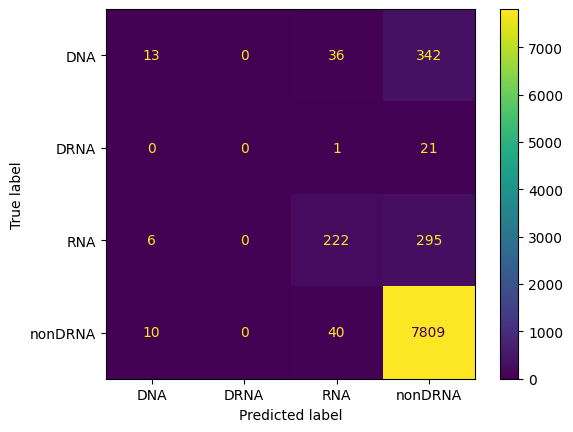

In [93]:
cm = confusion_matrix(y_encoded, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2,3])).plot()

In [104]:
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None, zero_division=0)[3]

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None, zero_division=0)[0]

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None, zero_division=0)[2]

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None, zero_division=0)[1]

def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None, zero_division=0)[3]

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None, zero_division=0)[0]

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None, zero_division=0)[2]

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None, zero_division=0)[1]

def spe_nonDRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None)[3]

def spe_DNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None)[0]

def spe_RNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None)[2]

def spe_DRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None)[1]

In [105]:
scoring = {
        'precision_nonDRNA':      make_scorer(prec_nonDRNA),
        'precision_DNA':          make_scorer(prec_DNA),
        'precision_RNA':          make_scorer(prec_RNA),
        'precision_DRNA':         make_scorer(prec_DRNA),
        'specificity_nonDRNA':    make_scorer(spe_nonDRNA),
        'specificity_DNA':        make_scorer(spe_DNA),
        'specificity_RNA':        make_scorer(spe_RNA),
        'specificity_DRNA':       make_scorer(spe_DRNA),
        'recall_nonDRNA':         make_scorer(rec_nonDRNA),
        'recall_DNA':             make_scorer(rec_DNA),
        'recall_RNA':             make_scorer(rec_RNA),
        'recall_DRNA':            make_scorer(rec_DRNA),
}

In [106]:
print('precision:')
for i, label in enumerate(le.inverse_transform([0,1,2,3])):
    print(f'   {label}: {precision_score(y_encoded, y_pred, average=None, zero_division=0)[i]}')
print('specificity:')
for i, label in enumerate(le.inverse_transform([0,1,2,3])):
    print(f'   {label}: {specificity_score(y_encoded, y_pred, average=None)[i]}')
print('recall:')
for i, label in enumerate(le.inverse_transform([0,1,2,3])):
    print(f'   {label}: {recall_score(y_encoded, y_pred, average=None, zero_division=0)[i]}')

precision:
   DNA: 0.4482758620689655
   DRNA: 0.0
   RNA: 0.7424749163879598
   nonDRNA: 0.9222865241525924
specificity:
   DNA: 0.9980961446930033
   DRNA: 1.0
   RNA: 0.9906914893617021
   nonDRNA: 0.297008547008547
recall:
   DNA: 0.03324808184143223
   DRNA: 0.0
   RNA: 0.42447418738049714
   nonDRNA: 0.9936378674131569


In [107]:
params = {
    "sampler": [RandomOverSampler(random_state=42), ADASYN(random_state=42), SMOTE(random_state=42), TomekLinks(), RandomUnderSampler(random_state=42)],
    'preprocessor': [StandardScaler(), MinMaxScaler(), QuantileTransformer(n_quantiles=50)]
}

net1 = Pipeline([
    ('sampler', 'passthrough'),
    ('preprocessor', StandardScaler()),
    ('dtype_transformer', dtype_transformer),
    ('classifier', net)
])

gs = GridSearchCV(net1, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [114]:
%%capture --no-stderr
gs.fit(X, y_encoded)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead 

In [109]:
results = pd.DataFrame(gs.cv_results_)

In [110]:
remove_cols = [x for x in list(results.columns) if 'split' in x] + ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
results_clean = results.drop(columns=remove_cols)


In [111]:
results_clean[[x for x in list(results.columns) if 'mean_test_precision' in x] + ['param_preprocessor', 'param_sampler']]


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,param_preprocessor,param_sampler
0,0.976808,0.164255,0.305797,0.019179,StandardScaler(),RandomOverSampler(random_state=42)
1,0.968048,0.170093,0.309289,0.015692,StandardScaler(),ADASYN(random_state=42)
2,0.967315,0.164137,0.322495,0.014589,StandardScaler(),SMOTE(random_state=42)
3,0.915675,0.200000,0.754090,0.000000,StandardScaler(),TomekLinks()
4,0.948477,0.078864,0.158719,0.007942,StandardScaler(),RandomUnderSampler(random_state=42)
5,0.972521,0.171190,0.373705,0.010179,MinMaxScaler(),RandomOverSampler(random_state=42)
6,0.969063,0.163270,0.389286,0.009138,MinMaxScaler(),ADASYN(random_state=42)
7,0.973945,0.155672,0.353312,0.009186,MinMaxScaler(),SMOTE(random_state=42)
8,0.893576,0.000000,0.000000,0.000000,MinMaxScaler(),TomekLinks()
9,0.884181,0.008333,0.087157,0.001665,MinMaxScaler(),RandomUnderSampler(random_state=42)


In [112]:
results_clean[[x for x in list(results.columns) if 'mean_test_specificity' in x] + ['param_preprocessor', 'param_sampler']]


,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,param_preprocessor,param_sampler
0,0.851513,0.851380,0.905587,0.979027,StandardScaler(),RandomOverSampler(random_state=42)
1,0.784242,0.868039,0.914288,0.981762,StandardScaler(),ADASYN(random_state=42)
2,0.778951,0.865301,0.918520,0.982560,StandardScaler(),SMOTE(random_state=42)
3,0.229730,0.999643,0.992868,1.000000,StandardScaler(),TomekLinks()
4,0.762920,0.795467,0.797364,0.856150,StandardScaler(),RandomUnderSampler(random_state=42)
5,0.830112,0.886119,0.934717,0.880534,MinMaxScaler(),RandomOverSampler(random_state=42)
6,0.795876,0.887791,0.932546,0.892505,MinMaxScaler(),ADASYN(random_state=42)
7,0.842968,0.876374,0.935687,0.862306,MinMaxScaler(),SMOTE(random_state=42)
8,0.000000,1.000000,1.000000,1.000000,MinMaxScaler(),TomekLinks()
9,0.788241,0.994170,0.738677,0.484451,MinMaxScaler(),RandomUnderSampler(random_state=42)


In [113]:
results_clean[[x for x in list(results.columns) if 'mean_test_recall' in x] + ['param_preprocessor', 'param_sampler']]


,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA,param_preprocessor,param_sampler
0,0.744624,0.624083,0.655861,0.14,StandardScaler(),RandomOverSampler(random_state=42)
1,0.772621,0.575430,0.604286,0.09,StandardScaler(),ADASYN(random_state=42)
2,0.774148,0.567705,0.613828,0.09,StandardScaler(),SMOTE(random_state=42)
3,0.996055,0.005128,0.347967,0.00,StandardScaler(),TomekLinks()
4,0.446636,0.337650,0.504396,0.43,StandardScaler(),RandomUnderSampler(random_state=42)
5,0.711022,0.485654,0.577546,0.48,MinMaxScaler(),RandomOverSampler(random_state=42)
6,0.724004,0.437131,0.554670,0.39,MinMaxScaler(),ADASYN(random_state=42)
7,0.685456,0.470756,0.548956,0.49,MinMaxScaler(),SMOTE(random_state=42)
8,1.000000,0.000000,0.000000,0.00,MinMaxScaler(),TomekLinks()
9,0.211323,0.005128,0.359853,0.55,MinMaxScaler(),RandomUnderSampler(random_state=42)


In [115]:
results[[x for x in list(results.columns) if 'rank' in x]].sum(axis=1)

0      67
1      79
2      80
3      86
4     131
5      67
6      84
7      79
8     116
9     134
10     73
11     90
12     94
13    102
14    144
dtype: int64

In [119]:
results_clean[[x for x in list(results.columns) if 'mean_test' in x]].iloc[0]

mean_test_precision_nonDRNA      0.976808
mean_test_precision_DNA          0.164255
mean_test_precision_RNA          0.305797
mean_test_precision_DRNA         0.019179
mean_test_specificity_nonDRNA    0.851513
mean_test_specificity_DNA        0.851380
mean_test_specificity_RNA        0.905587
mean_test_specificity_DRNA       0.979027
mean_test_recall_nonDRNA         0.744624
mean_test_recall_DNA             0.624083
mean_test_recall_RNA             0.655861
mean_test_recall_DRNA            0.140000
Name: 0, dtype: float64

In [120]:
results_clean[[x for x in list(results.columns) if 'mean_test' in x]].iloc[0]

mean_test_precision_nonDRNA      0.972521
mean_test_precision_DNA          0.171190
mean_test_precision_RNA          0.373705
mean_test_precision_DRNA         0.010179
mean_test_specificity_nonDRNA    0.830112
mean_test_specificity_DNA        0.886119
mean_test_specificity_RNA        0.934717
mean_test_specificity_DRNA       0.880534
mean_test_recall_nonDRNA         0.711022
mean_test_recall_DNA             0.485654
mean_test_recall_RNA             0.577546
mean_test_recall_DRNA            0.480000
Name: 5, dtype: float64

In [150]:
results_clean[['param_preprocessor', 'param_sampler']].iloc[[0,5]]

,param_preprocessor,param_sampler
0,StandardScaler(),RandomOverSampler(random_state=42)
5,MinMaxScaler(),RandomOverSampler(random_state=42)


These 2 are very close, the biggest difference I see between them is the specificity for DRNA on #0 is much bigger, but the recall for DRNA on #5 is much bigger.

In [192]:
params = {
    'preprocessor': [StandardScaler(), MinMaxScaler()],
    'classifier__module__activation_funct': [nn.ReLU, nn.ELU, nn.GELU],
    'classifier__module__num_units': range(11, 42, 5),
    'classifier__max_epochs': [10, 20, 30],
    'classifier__lr': [0.1, 0.01, 0.001]
}

net2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', StandardScaler()),
    ('dtype_transformer', dtype_transformer),
    ('classifier', net)
])

gs1 = GridSearchCV(net2, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

# PLEASE FOR THE LOVE OF GOD, DO NOT RUN THE CELL BELOW

In [193]:
gs1.fit(X, y_encoded)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead 

,estimator,Pipeline(step...tart=False))])
,param_grid,"{'classifier__lr': [0.1, 0.01, ...], 'classifier__max_epochs': [10, 20, ...], 'classifier__module__activation_funct': [<class 'torch...ivation.ReLU'>, <class 'torch...tivation.ELU'>, ...], 'classifier__module__num_units': range(11, 42, 5), ...}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [194]:
results2 = pd.DataFrame(gs1.cv_results_)


In [195]:
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__lr,param_classifier__max_epochs,param_classifier__module__activation_funct,param_classifier__module__num_units,param_preprocessor,params,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,10.616678,0.281621,0.151691,0.027322,0.100,10,<class 'torch.nn.modules.activation.ReLU'>,11,StandardScaler(),"{'classifier__lr': 0.1, 'classifier__max_epoch...",...,0.074037,143,0.25,0.25,0.25,0.4,0.0,0.23,0.128841,298
1,9.103177,1.430136,0.088630,0.027628,0.100,10,<class 'torch.nn.modules.activation.ReLU'>,11,MinMaxScaler(),"{'classifier__lr': 0.1, 'classifier__max_epoch...",...,0.049874,204,0.50,0.75,0.75,0.6,0.8,0.68,0.112250,2
2,7.102475,0.141173,0.074192,0.010188,0.100,10,<class 'torch.nn.modules.activation.ReLU'>,16,StandardScaler(),"{'classifier__lr': 0.1, 'classifier__max_epoch...",...,0.046406,147,0.00,0.25,0.25,0.2,0.0,0.14,0.115758,330
3,7.520893,0.256291,0.069545,0.007229,0.100,10,<class 'torch.nn.modules.activation.ReLU'>,16,MinMaxScaler(),"{'classifier__lr': 0.1, 'classifier__max_epoch...",...,0.076171,271,0.25,0.25,0.25,0.6,0.8,0.43,0.229347,119
4,7.570005,0.262019,0.077129,0.007616,0.100,10,<class 'torch.nn.modules.activation.ReLU'>,21,StandardScaler(),"{'classifier__lr': 0.1, 'classifier__max_epoch...",...,0.041911,104,0.00,0.25,0.25,0.2,0.0,0.14,0.115758,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,22.660304,0.536735,0.059094,0.003711,0.001,30,<class 'torch.nn.modules.activation.GELU'>,31,MinMaxScaler(),"{'classifier__lr': 0.001, 'classifier__max_epo...",...,0.280561,347,0.25,0.00,0.75,0.4,1.0,0.48,0.355809,52
374,21.712327,0.339716,0.061248,0.003388,0.001,30,<class 'torch.nn.modules.activation.GELU'>,36,StandardScaler(),"{'classifier__lr': 0.001, 'classifier__max_epo...",...,0.063034,64,0.25,0.50,0.25,0.6,0.6,0.44,0.159374,86
375,21.713689,0.114832,0.059872,0.004314,0.001,30,<class 'torch.nn.modules.activation.GELU'>,36,MinMaxScaler(),"{'classifier__lr': 0.001, 'classifier__max_epo...",...,0.272735,359,0.00,0.50,0.00,0.0,0.4,0.18,0.222711,316
376,21.633815,0.378706,0.054822,0.005345,0.001,30,<class 'torch.nn.modules.activation.GELU'>,41,StandardScaler(),"{'classifier__lr': 0.001, 'classifier__max_epo...",...,0.064273,123,0.00,0.50,0.25,0.6,0.6,0.39,0.233238,185


In [196]:
results2['param_preprocessor'] = results2['param_preprocessor'].apply(str)
results2['param_classifier__module__activation_funct'] = results2['param_classifier__module__activation_funct'].apply(str)
ss_results = results2[results2['param_preprocessor'] == 'StandardScaler()']
ros_results = results2[results2['param_preprocessor'] == 'RandomOverSampler(random_state=42)']

In [197]:
[x for x in results2.columns if 'param' in x]

['param_classifier__lr',
 'param_classifier__max_epochs',
 'param_classifier__module__activation_funct',
 'param_classifier__module__num_units',
 'param_preprocessor',
 'params']

In [198]:
[x for x in results2.columns if 'mean' in x and 'time' not in x]

['mean_test_precision_nonDRNA',
 'mean_test_precision_DNA',
 'mean_test_precision_RNA',
 'mean_test_precision_DRNA',
 'mean_test_specificity_nonDRNA',
 'mean_test_specificity_DNA',
 'mean_test_specificity_RNA',
 'mean_test_specificity_DRNA',
 'mean_test_recall_nonDRNA',
 'mean_test_recall_DNA',
 'mean_test_recall_RNA',
 'mean_test_recall_DRNA']

In [199]:
results2['param_classifier__module__activation_funct'].unique()

array(["<class 'torch.nn.modules.activation.ReLU'>",
       "<class 'torch.nn.modules.activation.ELU'>",
       "<class 'torch.nn.modules.activation.GELU'>"], dtype=object)

In [200]:
results2.groupby(by='param_classifier__module__activation_funct')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()



,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__module__activation_funct,,,,,,,,,,,,
<class 'torch.nn.modules.activation.ELU'>,0.948665,0.136860,0.274262,0.010098,0.806714,0.870617,0.881356,0.875485,0.634762,0.415402,0.562024,0.356587
<class 'torch.nn.modules.activation.GELU'>,0.929808,0.130474,0.263187,0.011181,0.807707,0.858003,0.879095,0.850276,0.593495,0.402492,0.531558,0.371984
<class 'torch.nn.modules.activation.ReLU'>,0.941278,0.128238,0.263006,0.010417,0.809607,0.863084,0.872382,0.865024,0.607087,0.407021,0.551283,0.348175


ELU is the best activation function on average

In [201]:
results2.groupby(by='param_classifier__max_epochs')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__max_epochs,,,,,,,,,,,,
10,0.913364,0.122520,0.256817,0.009320,0.803459,0.849263,0.872213,0.850900,0.578012,0.398572,0.521033,0.365000
20,0.950314,0.135239,0.268088,0.011179,0.809681,0.866802,0.878417,0.864191,0.616198,0.412172,0.551235,0.362778
30,0.956073,0.137812,0.275552,0.011198,0.810888,0.875640,0.882203,0.875694,0.641134,0.414172,0.572597,0.348968


30 epocks is better for all categories on average except for DRNA recall

In [202]:
results2.groupby(by='param_classifier__lr')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__lr,,,,,,,,,,,,
0.001,0.877585,0.090584,0.176342,0.005527,0.766220,0.842178,0.825258,0.794237,0.464839,0.283581,0.433719,0.370000
0.010,0.968135,0.148912,0.295419,0.009227,0.820015,0.894650,0.894205,0.864310,0.661576,0.389810,0.601783,0.407460
0.100,0.974031,0.156075,0.328694,0.016943,0.837793,0.854877,0.913370,0.932239,0.708929,0.551525,0.609363,0.299286


In [203]:
results2.groupby(['param_classifier__lr', 'param_classifier__max_epochs'])[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()


mean_test_precision_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                
0.001                10                                               0.801897   
                     20                                               0.907202   
                     30                                               0.923655   
0.010                10                                               0.963535   
                     20                                               0.969364   
                     30                                               0.971506   
0.100                10                                               0.974660   
                     20                                               0.974375   
                     30                                               0.973059   

                                                   mean_test_precision_DNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.072989   
                     20                                           0.097207   
                     30                                           0.101557   
0.010                10                                           0.139426   
                     20                                           0.152576   
                     30                                           0.154735   
0.100                10                                           0.155147   
                     20                                           0.155932   
                     30                                           0.157146   

                                                   mean_test_precision_RNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.133917   
                     20                                           0.186504   
                     30                                           0.208607   
0.010                10                                           0.292350   
                     20                                           0.296572   
                     30                                           0.297335   
0.100                10                                           0.344183   
                     20                                           0.321187   
                     30                                           0.320713   

                                                   mean_test_precision_DRNA  \
param_classifier__lr param_classifier__max_epochs                             
0.001                10                                            0.005356   
                     20                                            0.005196   
                     30                                            0.006030   
0.010                10                                            0.008588   
                     20                                            0.009352   
                     30                                            0.009741   
0.100                10                                            0.014017   
                     20                                            0.018988   
                     30                                            0.017822   

                                                   mean_test_specificity_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                  
0.001                10                                                 0.766289   
                     20                                                 0.763189   
                     30                                                 0.769181   
0.010                10                                                 0.801236   
                     20                                 

lower learning rate with more epochs seems like the way to go

In [204]:
results2.groupby(['param_classifier__lr', 'param_classifier__max_epochs'])[[x for x in results2.columns if 'mean' in x and 'time' not in x]].max()


mean_test_precision_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                
0.001                10                                               0.969146   
                     20                                               0.975166   
                     30                                               0.974083   
0.010                10                                               0.975687   
                     20                                               0.976150   
                     30                                               0.978152   
0.100                10                                               0.982043   
                     20                                               0.980886   
                     30                                               0.981238   

                                                   mean_test_precision_DNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.240252   
                     20                                           0.228372   
                     30                                           0.163894   
0.010                10                                           0.182483   
                     20                                           0.196046   
                     30                                           0.182567   
0.100                10                                           0.199870   
                     20                                           0.202832   
                     30                                           0.197238   

                                                   mean_test_precision_RNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.275569   
                     20                                           0.312021   
                     30                                           0.445679   
0.010                10                                           0.374914   
                     20                                           0.360118   
                     30                                           0.362656   
0.100                10                                           0.461957   
                     20                                           0.428936   
                     30                                           0.424355   

                                                   mean_test_precision_DRNA  \
param_classifier__lr param_classifier__max_epochs                             
0.001                10                                            0.041020   
                     20                                            0.010813   
                     30                                            0.010354   
0.010                10                                            0.014931   
                     20                                            0.016849   
                     30                                            0.017727   
0.100                10                                            0.025139   
                     20                                            0.045005   
                     30                                            0.033903   

                                                   mean_test_specificity_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                  
0.001                10                                                 0.970213   
                     20                                                 0.904841   
                     30                                                 0.932620   
0.010                10                                                 0.863158   
                     20                                 

In [205]:
results2.groupby(by='param_classifier__module__num_units')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__module__num_units,,,,,,,,,,,,
11,0.921732,0.121395,0.256353,0.009966,0.814412,0.852028,0.854310,0.862586,0.574792,0.404995,0.541677,0.360926
16,0.930671,0.130054,0.261366,0.009642,0.808665,0.862681,0.870530,0.863000,0.602824,0.403507,0.546392,0.351667
21,0.922933,0.133131,0.264077,0.010648,0.817839,0.862976,0.874257,0.853160,0.596911,0.403468,0.549261,0.374815
26,0.954066,0.134563,0.266831,0.010392,0.804095,0.862226,0.878617,0.870924,0.617998,0.420681,0.551019,0.348519
31,0.948447,0.133276,0.266004,0.010355,0.800764,0.878097,0.883039,0.855459,0.623225,0.394052,0.551476,0.360926
36,0.943687,0.136531,0.276164,0.010809,0.807154,0.860945,0.894080,0.869010,0.631511,0.420432,0.545278,0.351852
41,0.957883,0.134050,0.276935,0.012147,0.803136,0.868357,0.888444,0.871026,0.635211,0.411001,0.552915,0.363704


the range 21 - 31 appears to have the most consistently high values accross the board

In [206]:
results2.groupby(by='param_preprocessor')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].mean()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_preprocessor,,,,,,,,,,,,
MinMaxScaler(),0.908720,0.118801,0.239968,0.006388,0.782982,0.871141,0.859900,0.810813,0.547627,0.312224,0.488960,0.387302
StandardScaler(),0.971114,0.144914,0.293669,0.014743,0.833037,0.856662,0.895323,0.916377,0.675936,0.504386,0.607616,0.330529


Standard Scalar is the best overall

In [207]:
results2.groupby(by='param_preprocessor')[[x for x in results2.columns if 'mean' in x and 'time' not in x]].max()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_preprocessor,,,,,,,,,,,,
MinMaxScaler(),0.982043,0.240252,0.461957,0.041020,0.970213,0.997620,0.999758,0.996125,0.778080,0.647257,0.700037,0.75
StandardScaler(),0.978152,0.169039,0.366607,0.045005,0.925236,0.928479,0.934356,0.991451,0.780381,0.654722,0.676923,0.58


although minmax has the higher peak, I will go with standard scaler

Standard Scalar wins

So far:
 - StandardScaler() is the best preprocesser
 - smaller number of units appear to be more effective
 - ELU is best activation function
 - number of epocks and learning rate are undecided

In [210]:

# and results2['param_classifier__module__activation_funct']

results2_filtered = results2[results2['param_preprocessor'] == 'StandardScaler()']
results2_filtered = results2_filtered[results2_filtered['param_classifier__module__activation_funct'] == "<class 'torch.nn.modules.activation.ELU'>"]
results2_filtered = results2_filtered[results2_filtered['param_classifier__module__num_units'] < 32]
results2_filtered = results2_filtered[results2_filtered['param_classifier__module__num_units'] > 20]


In [211]:
results2_filtered.groupby(['param_classifier__lr', 'param_classifier__max_epochs'])[[x for x in results2_filtered.columns if 'mean' in x and 'time' not in x]].mean()


mean_test_precision_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                
0.001                10                                               0.968087   
                     20                                               0.970514   
                     30                                               0.971050   
0.010                10                                               0.973802   
                     20                                               0.974815   
                     30                                               0.974986   
0.100                10                                               0.975038   
                     20                                               0.974415   
                     30                                               0.972922   

                                                   mean_test_precision_DNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.121301   
                     20                                           0.140371   
                     30                                           0.153273   
0.010                10                                           0.163181   
                     20                                           0.161702   
                     30                                           0.158081   
0.100                10                                           0.155739   
                     20                                           0.158254   
                     30                                           0.158570   

                                                   mean_test_precision_RNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.200703   
                     20                                           0.285545   
                     30                                           0.311186   
0.010                10                                           0.351139   
                     20                                           0.336324   
                     30                                           0.341021   
0.100                10                                           0.331234   
                     20                                           0.313935   
                     30                                           0.297342   

                                                   mean_test_precision_DRNA  \
param_classifier__lr param_classifier__max_epochs                             
0.001                10                                            0.007086   
                     20                                            0.008339   
                     30                                            0.008603   
0.010                10                                            0.010647   
                     20                                            0.010390   
                     30                                            0.010480   
0.100                10                                            0.014112   
                     20                                            0.026905   
                     30                                            0.027415   

                                                   mean_test_specificity_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                  
0.001                10                                                 0.839043   
                     20                                                 0.831202   
                     30                                                 0.825156   
0.010                10                                                 0.839430   
                     20                                 

The next thing I want to try for training is more epochs on 0.001 lr

In [212]:
results2_filtered.groupby(['param_classifier__lr', 'param_classifier__max_epochs'])[[x for x in results2_filtered.columns if 'mean' in x and 'time' not in x]].max()


mean_test_precision_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                
0.001                10                                               0.969080   
                     20                                               0.971015   
                     30                                               0.972424   
0.010                10                                               0.974368   
                     20                                               0.975421   
                     30                                               0.976137   
0.100                10                                               0.975517   
                     20                                               0.975673   
                     30                                               0.974810   

                                                   mean_test_precision_DNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.125402   
                     20                                           0.152608   
                     30                                           0.157757   
0.010                10                                           0.166957   
                     20                                           0.164084   
                     30                                           0.160997   
0.100                10                                           0.158064   
                     20                                           0.169039   
                     30                                           0.161255   

                                                   mean_test_precision_RNA  \
param_classifier__lr param_classifier__max_epochs                            
0.001                10                                           0.229349   
                     20                                           0.292206   
                     30                                           0.341443   
0.010                10                                           0.357467   
                     20                                           0.339450   
                     30                                           0.345968   
0.100                10                                           0.335475   
                     20                                           0.329375   
                     30                                           0.311069   

                                                   mean_test_precision_DRNA  \
param_classifier__lr param_classifier__max_epochs                             
0.001                10                                            0.007979   
                     20                                            0.008866   
                     30                                            0.008994   
0.010                10                                            0.010996   
                     20                                            0.011358   
                     30                                            0.010740   
0.100                10                                            0.016901   
                     20                                            0.031719   
                     30                                            0.032319   

                                                   mean_test_specificity_nonDRNA  \
param_classifier__lr param_classifier__max_epochs                                  
0.001                10                                                 0.862174   
                     20                                                 0.839771   
                     30                                                 0.836563   
0.010                10                                                 0.842991   
                     20                                 

In [213]:
results2_filtered[(results2_filtered['param_classifier__lr'] == 0.001) & (results2_filtered['param_classifier__max_epochs'] == 10)][['param_classifier__module__num_units'] + [x for x in results2_filtered.columns if 'mean' in x and 'time' not in x]]


,param_classifier__module__num_units,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
270,21,0.968144,0.117687,0.190869,0.006932,0.862174,0.869708,0.792571,0.796874,0.458705,0.352840,0.608223,0.54
272,26,0.967038,0.120813,0.229349,0.007979,0.809887,0.880418,0.861596,0.870045,0.621464,0.350795,0.568223,0.39
274,31,0.969080,0.125402,0.181890,0.006347,0.845068,0.888034,0.826890,0.840987,0.564321,0.324667,0.594597,0.39


In [214]:
results2_filtered.groupby(by='param_classifier__module__num_units')[[x for x in results2_filtered.columns if 'mean' in x and 'time' not in x]].mean()


,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__module__num_units,,,,,,,,,,,,
21,0.973031,0.150652,0.308178,0.014169,0.839775,0.867590,0.904176,0.906745,0.686954,0.502676,0.608059,0.365556
26,0.973067,0.154831,0.305561,0.013505,0.835271,0.871385,0.906231,0.917497,0.703893,0.507043,0.617462,0.335556
31,0.972444,0.151340,0.309071,0.013652,0.833477,0.870338,0.907292,0.914040,0.700315,0.497526,0.616978,0.332222


 - Check 21 < num_units < 31  = \[20,24,28,30\]
 - lr = 0.001
 - epochs = \[10, 20, 30, 40, 50\]

In [215]:
net_last_test = NeuralNetClassifier(
    MPLClassifier,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    lr=0.001,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks='disable',
    module__activation_funct = nn.ELU,
    
)

params = {
    'classifier__module__num_units': [20,24,28,30],
    'classifier__max_epochs': [10, 20, 30, 40, 50]
}

net3 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', StandardScaler()),
    ('dtype_transformer', dtype_transformer),
    ('classifier', net_last_test)
])

gs2 = GridSearchCV(net3, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [216]:
gs2.fit(X, y_encoded)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead 

,estimator,Pipeline(step...tart=False))])
,param_grid,"{'classifier__max_epochs': [10, 20, ...], 'classifier__module__num_units': [20, 24, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [217]:
results_last = pd.DataFrame(gs2.cv_results_)
results_last

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_epochs,param_classifier__module__num_units,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,split2_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,17.399079,0.573207,0.140321,0.030076,10,20,"{'classifier__max_epochs': 10, 'classifier__mo...",0.949378,0.974265,0.953807,...,0.043161,8,0.00,0.75,0.25,0.8,0.6,0.48,0.307571,9
1,13.995754,3.748547,0.148081,0.067201,10,24,"{'classifier__max_epochs': 10, 'classifier__mo...",0.966805,0.985043,0.960452,...,0.083869,19,0.50,0.50,0.25,0.6,0.6,0.49,0.128062,4
2,8.790256,0.109598,0.067097,0.001950,10,28,"{'classifier__max_epochs': 10, 'classifier__mo...",0.980085,0.964444,0.954769,...,0.109110,20,0.25,0.75,0.25,0.8,0.6,0.53,0.237908,2
3,7.716483,0.490385,0.073786,0.009958,10,30,"{'classifier__max_epochs': 10, 'classifier__mo...",0.968785,0.973807,0.966474,...,0.048833,18,0.25,0.50,0.50,0.8,0.6,0.53,0.177764,2
4,15.153930,0.207426,0.062622,0.004759,20,20,"{'classifier__max_epochs': 20, 'classifier__mo...",0.971625,0.972194,0.961221,...,0.029206,5,0.25,0.50,0.25,0.8,0.6,0.48,0.211187,9
5,15.013281,0.587389,0.054912,0.004610,20,24,"{'classifier__max_epochs': 20, 'classifier__mo...",0.973790,0.977408,0.961285,...,0.066750,4,0.25,0.50,0.25,0.8,0.6,0.48,0.211187,9
6,14.030103,0.493441,0.069550,0.013484,20,28,"{'classifier__max_epochs': 20, 'classifier__mo...",0.978162,0.965187,0.961336,...,0.060039,15,0.00,0.50,0.25,0.6,0.6,0.39,0.233238,15
7,13.852677,0.152109,0.057892,0.003380,20,30,"{'classifier__max_epochs': 20, 'classifier__mo...",0.975855,0.970136,0.958191,...,0.044345,3,0.00,0.50,0.25,0.6,0.6,0.39,0.233238,15
8,21.258299,0.173381,0.073336,0.014226,30,20,"{'classifier__max_epochs': 30, 'classifier__mo...",0.976281,0.973776,0.964587,...,0.065262,1,0.00,0.50,0.25,0.6,0.6,0.39,0.233238,15
9,20.542896,0.814617,0.065262,0.009357,30,24,"{'classifier__max_epochs': 30, 'classifier__mo...",0.974291,0.968360,0.968917,...,0.038797,9,0.00,0.50,0.25,0.6,0.6,0.39,0.233238,15


In [218]:
results_last.groupby(by='param_classifier__max_epochs')[[x for x in results_last.columns if 'mean' in x and 'time' not in x]].mean()



,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__max_epochs,,,,,,,,,,,,
10,0.965155,0.119306,0.220666,0.008749,0.822400,0.857243,0.851242,0.852441,0.564070,0.386271,0.589826,0.5075
20,0.970305,0.148152,0.264984,0.007966,0.833046,0.886338,0.883253,0.864066,0.640504,0.403554,0.619130,0.4350
30,0.970639,0.158993,0.319797,0.008103,0.822113,0.895884,0.915075,0.879115,0.699164,0.420797,0.616268,0.3900
40,0.971877,0.166509,0.345984,0.010545,0.826415,0.895526,0.927014,0.881423,0.713227,0.447549,0.610041,0.5025
50,0.971247,0.163451,0.361887,0.009408,0.822675,0.889339,0.932181,0.882734,0.712463,0.464143,0.609084,0.4450


40 epochs

In [219]:
results_last.groupby(by='param_classifier__module__num_units')[[x for x in results_last.columns if 'mean' in x and 'time' not in x]].mean()



,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
param_classifier__module__num_units,,,,,,,,,,,,
20,0.969215,0.150067,0.296003,0.009447,0.821142,0.889530,0.895020,0.874772,0.666266,0.411782,0.620352,0.468
24,0.969897,0.149621,0.299570,0.009134,0.827575,0.875158,0.900145,0.871239,0.653084,0.431749,0.605795,0.468
28,0.969722,0.151189,0.315503,0.008424,0.822887,0.886746,0.907857,0.870804,0.673217,0.426173,0.601227,0.440
30,0.970544,0.154254,0.299578,0.008813,0.829714,0.888030,0.903990,0.871009,0.670974,0.428147,0.608106,0.448


20 units

In [222]:
results_last[results_last['param_classifier__max_epochs'] == 40][['param_classifier__module__num_units'] + [x for x in results_last.columns if 'mean' in x and 'time' not in x]]



,param_classifier__module__num_units,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
12,20,0.971243,0.167421,0.336202,0.011592,0.823740,0.895763,0.921906,0.883960,0.709252,0.449984,0.627253,0.54
13,24,0.971538,0.169480,0.337760,0.009884,0.824792,0.898621,0.924687,0.878030,0.710519,0.442519,0.608168,0.49
14,28,0.971808,0.163460,0.352000,0.010226,0.823751,0.900406,0.928556,0.880882,0.720577,0.416943,0.611978,0.49
15,30,0.972920,0.165674,0.357973,0.010479,0.833377,0.887314,0.932906,0.882820,0.712559,0.480753,0.592766,0.49


the final model:
- Random Oversampler
- Standard Scaler
- 20 units
- Exponential Linear Units activation function
- 40 epochs
- 0.001 learning rate

In [244]:
net_final = NeuralNetClassifier(
    MPLClassifier,
    max_epochs=40,
    criterion=nn.CrossEntropyLoss(),
    lr=0.001,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks='disable',
    module__activation_funct = nn.ELU,
    module__num_units = 20
    
)

pipe = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', StandardScaler()),
    ('dtype_transformer', FunctionTransformer(datatype_correction)),
    ('classifier', net_final)
])

y_pred = cross_val_predict(pipe, X, y_encoded, cv=5)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead 

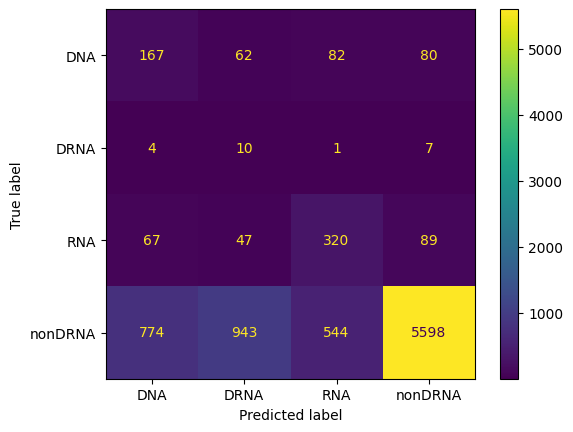

In [245]:
cm = confusion_matrix(y_encoded, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2,3])).plot()